In [21]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [22]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [35]:
train = pd.read_csv("../../google-clusterdata/data/borg_traces_data.csv")
train.head()

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0,2,94591244395,3,1,200,0,144,168846390496,...,0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,...,0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,2,195684022913,6,276227177776,2,0,103,0,376,169321752432,...,0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,3,0,2,10507389885,3,0,200,0,1977,178294817221,...,0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1
4,4,1810627494172,3,25911621841,2,0,0,0,3907,231364893292,...,0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Unnamed: 0                       405894 non-null  int64         
 1   time                             405894 non-null  datetime64[ns]
 2   instance_events_type             405894 non-null  int64         
 3   collection_id                    405894 non-null  int64         
 4   scheduling_class                 405894 non-null  int64         
 5   collection_type                  405894 non-null  int64         
 6   priority                         405894 non-null  int64         
 7   alloc_collection_id              405894 non-null  int64         
 8   instance_index                   405894 non-null  int64         
 9   machine_id                       405894 non-null  int64         
 10  resource_request                 405120 non-

In [27]:
train.isna().sum()

Unnamed: 0                              0
time                                    0
instance_events_type                    0
collection_id                           0
scheduling_class                        0
collection_type                         0
priority                                0
alloc_collection_id                     0
instance_index                          0
machine_id                              0
resource_request                      774
constraint                              0
collections_events_type                 0
user                                    0
collection_name                         0
collection_logical_name                 0
start_after_collection_ids              0
vertical_scaling                      959
scheduler                             959
start_time                              0
end_time                                0
average_usage                           0
maximum_usage                           0
random_sample_usage               

In [29]:
train[["assigned_memory", "page_cache_memory", "cycles_per_instruction",
    "memory_accesses_per_instruction", "sample_rate", "failed"]].describe()

,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,failed
count,405894.000000,405894.000000,281206.000000,281206.000000,405894.000000,405894.000000
mean,0.008927,0.000398,2.185379,0.010722,0.999223,0.228331
std,0.024937,0.000550,1.256117,0.007753,0.010239,0.419757
min,0.000000,0.000000,0.252846,0.000125,0.110000,0.000000
25%,0.000196,0.000008,1.067229,0.004329,1.000000,0.000000
50%,0.002693,0.000227,1.918681,0.009506,1.000000,0.000000
75%,0.006683,0.000539,3.156894,0.016435,1.000000,0.000000
max,0.286133,0.008453,105.275932,0.084292,1.000000,1.000000


failed distribution

In [32]:
failed_distribution = pd.DataFrame(train["failed"].value_counts())
failed_distribution.reset_index(inplace=True)
failed_distribution.columns=["failed", "number"]
failed_distribution

,failed,number
0,0,313216
1,1,92678


cluster distribution

In [30]:
cluster_distribution = pd.DataFrame(train["cluster"].value_counts())
cluster_distribution.reset_index(inplace=True)
cluster_distribution.columns=["cluster", "number"]
cluster_distribution

,cluster,number
0,3,58783
1,6,58531
2,4,55502
3,7,50360
4,5,48657
5,8,46931
6,2,44417
7,1,42713


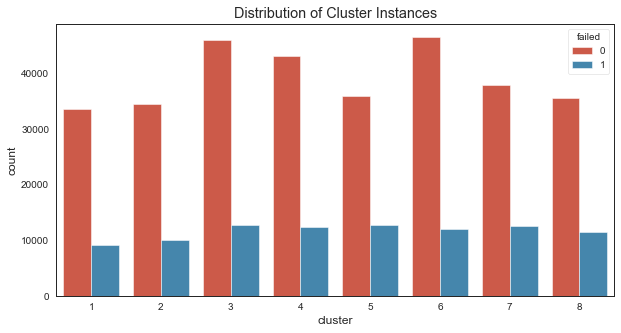

In [34]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Cluster Instances")
sns.countplot(x="cluster", data=train, hue="failed")
plt.show()